# Spaceship Titanic

Описание набора: персональные данные пассажиров.
Цель: предсказать, переместится ли пассажир в альтернативное измерение во время столкновения космического корабля с пространственно-временной аномалией.

Метрика оценки: Accuracy \
Бинарная классификация

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Загрузка и подготовка данных

In [2]:
df = pd.read_csv('C:/Users/Alexandra/Jupyter/ML/Задания/Дз 2/train.csv')
df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
df.shape

(8693, 14)

In [4]:
df.describe().round(2)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,28.83,224.69,458.08,173.73,311.14,304.85
std,14.49,666.72,1611.49,604.70,1136.71,1145.72
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,47.00,76.00,27.00,59.00,46.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00


In [5]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

### Первичный вывод:
1) Можно объединить признаки RoomService, FoodCourt, ShoppingMall, Spa, VRDeck в один признак. 
2) Необходимо обработать пропуски. 
3) True/False нужно преобразовать в 0/1 для корреляции. 
4) От PassengerId и Name целевой признак, скорее всего, не зависит. 
5) Необходимо как-то преобразовать тип кают.

## Feature engineering

### 1) Можно объединить признаки RoomService, FoodCourt, ShoppingMall, Spa, VRDeck в один признак.

In [6]:
df['TotalSpent'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis = 1)
df['HasSpent'] = (df['TotalSpent'] > 0).astype(int)

In [7]:
df.groupby('Transported')[['TotalSpent', 'HasSpent']].mean()

,TotalSpent,HasSpent
Transported,,
False,2004.149247,0.819235
True,885.689127,0.343764


<Axes: >

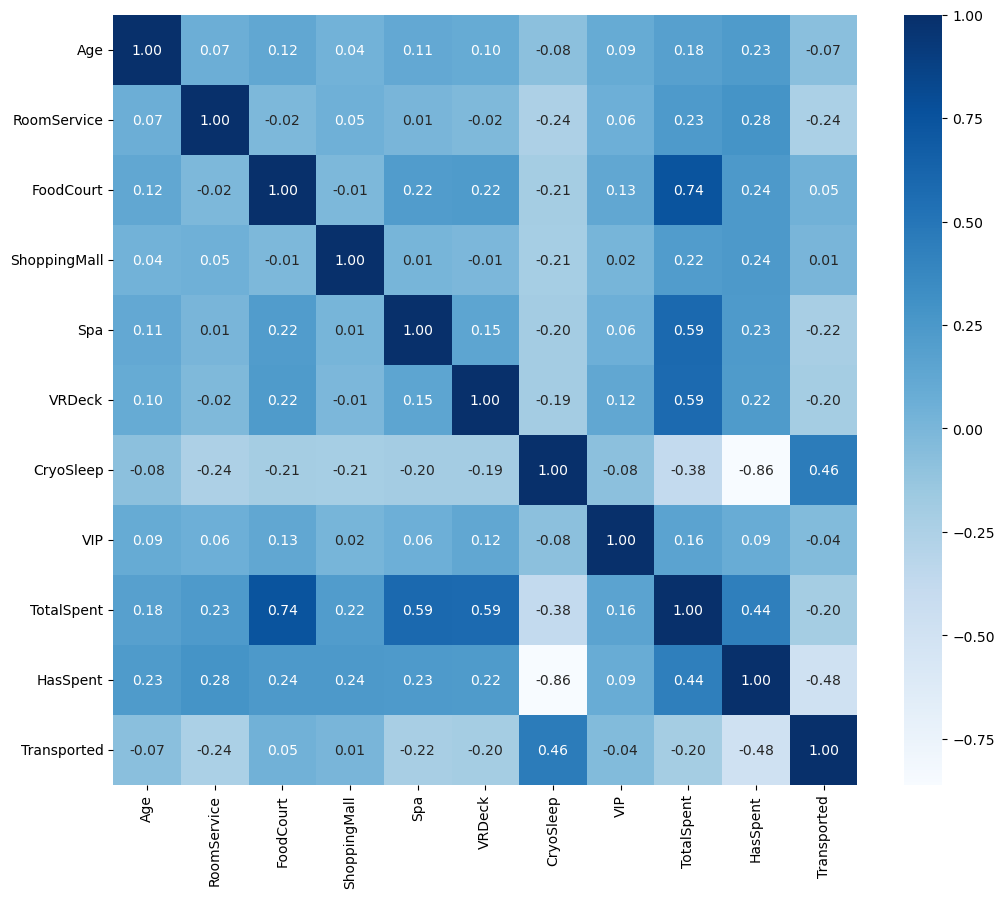

In [8]:
spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for col in df:
    df[col] = df[col].fillna(0)

df['CryoSleep'] = df['CryoSleep'].astype(int)
df['VIP'] = df['VIP'].astype(int)

numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CryoSleep', 'VIP', 'TotalSpent', 'HasSpent', 'Transported']
plt.figure(figsize=(12, 10))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot = True, fmt='.2f', cmap='Blues')

из матрицы корреляций видно, что больше всего влияние имеет CryoSleep, а отрицательную корреляцию дает признак HasSpent.

Обучим модель и посмотрим, какие признаки важны

In [9]:
def prepare_features(df):
    features = pd.DataFrame()
    features['Age'] = df['Age'].fillna(df['Age'].median())

    features['HasSpent'] = df['HasSpent']
    features['TotalSpent'] = df['TotalSpent']
    features['CryoSleep'] = df['CryoSleep']
    features['VIP'] = df['VIP']

    return features

X = prepare_features(df)
y = df['Transported']

In [10]:
X.head()

,Age,HasSpent,TotalSpent,CryoSleep,VIP
0,39.0,0,0.0,0,0
1,24.0,1,736.0,0,0
2,58.0,1,10383.0,0,1
3,33.0,1,5176.0,0,0
4,16.0,1,1091.0,0,0


Важность признаков:
      feature  importance
2  TotalSpent    0.635003
0         Age    0.168125
1    HasSpent    0.121883
3   CryoSleep    0.072919
4         VIP    0.002070


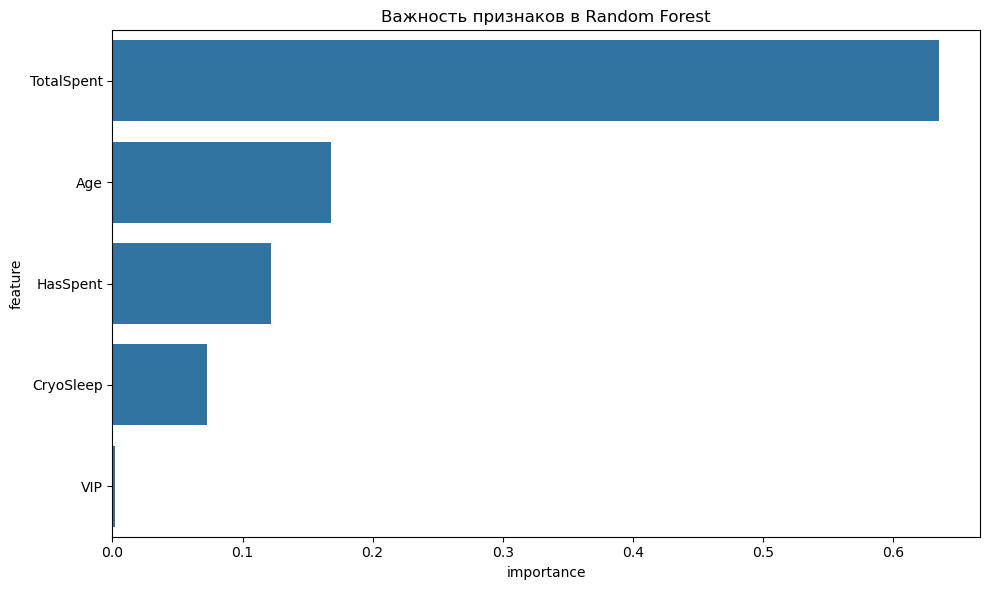

In [11]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Важность признаков:")
print(feature_importance)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Важность признаков в Random Forest')
plt.tight_layout()
plt.show()

На основе результатов можно сделать вывод, что столбец VIP можно убрать, он почти не важен для модели.

In [12]:
df = df.drop(columns = 'VIP')

In [13]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TotalSpent,HasSpent
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,0
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0,1
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,10383.0,1
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5176.0,1
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1091.0,1


Оценим, насколько важны признаки, входящие в TotalSpent

Важность всех признаков:
        feature  importance
5    TotalSpent    0.184834
1     FoodCourt    0.121009
3           Spa    0.108081
0   RoomService    0.107380
7           Age    0.105159
6      HasSpent    0.103310
4        VRDeck    0.099500
2  ShoppingMall    0.095940
8     CryoSleep    0.074786


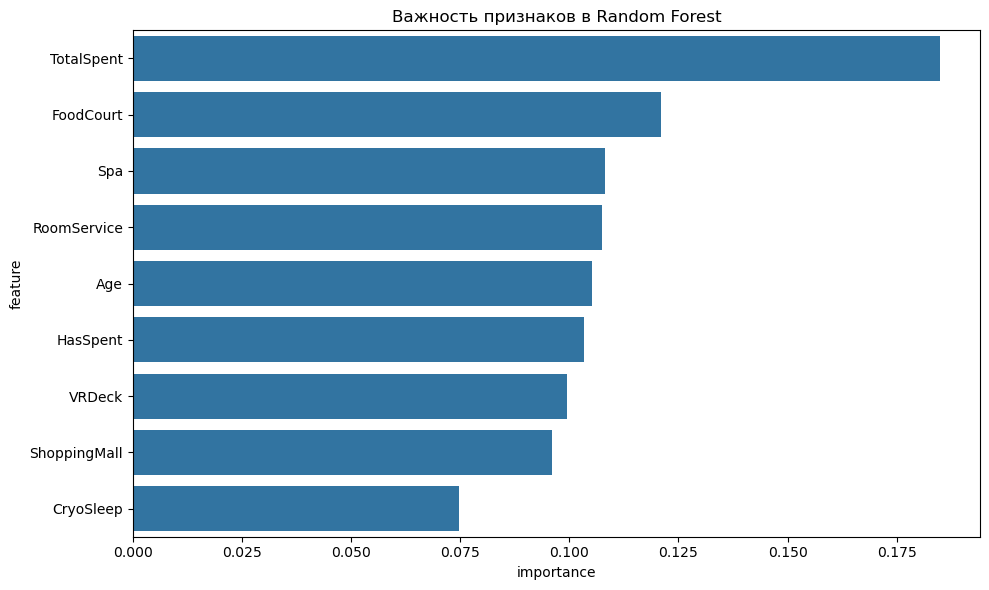

In [14]:
X_experiment = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 
                           'TotalSpent', 'HasSpent', 'Age', 'CryoSleep']]
rf_exp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_exp.fit(X_experiment, y)

importance_df = pd.DataFrame({
    'feature': X_experiment.columns,
    'importance': rf_exp.feature_importances_
}).sort_values('importance', ascending=False)

print("Важность всех признаков:")
print(importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(importance_df, x='importance', y='feature')
plt.title('Важность признаков в Random Forest')
plt.tight_layout()
plt.show()

Все признаки важны, удалять нельзя

### 5) Необходимо как-то преобразовать тип кают.

In [15]:
train_data = df

def process_cabin(df):
    df['Cabin'] = df['Cabin'].fillna('Unknown/Unknown/Unknown')
    cabin_split = df['Cabin'].str.split('/', expand=True)
    
    df['Deck'] = cabin_split[0]      
    df['CabinNum'] = cabin_split[1]   
    df['Side'] = cabin_split[2]
    
    df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce')

    df.loc[df['Deck'] == 'Unknown', 'Deck'] = np.nan
    df.loc[df['Side'] == 'Unknown', 'Side'] = np.nan

    return df

train_data = process_cabin(train_data)

print("\nСтатистика по палубам:")
print(train_data['Deck'].value_counts(dropna=False))

print("\nСтатистика по сторонам:")
print(train_data['Side'].value_counts(dropna=False))

print("\nСтатистика по номеру каюты:")
print(train_data['CabinNum'].describe())


Статистика по палубам:
Deck
F      2794
G      2559
E       876
B       779
C       747
D       478
A       256
NaN     199
T         5
Name: count, dtype: int64

Статистика по сторонам:
Side
S      4288
P      4206
NaN     199
Name: count, dtype: int64

Статистика по номеру каюты:
count    8494.000000
mean      600.367671
std       511.867226
min         0.000000
25%       167.250000
50%       427.000000
75%       999.000000
max      1894.000000
Name: CabinNum, dtype: float64


Text(0.5, 1.0, 'Распределение номеров кают')

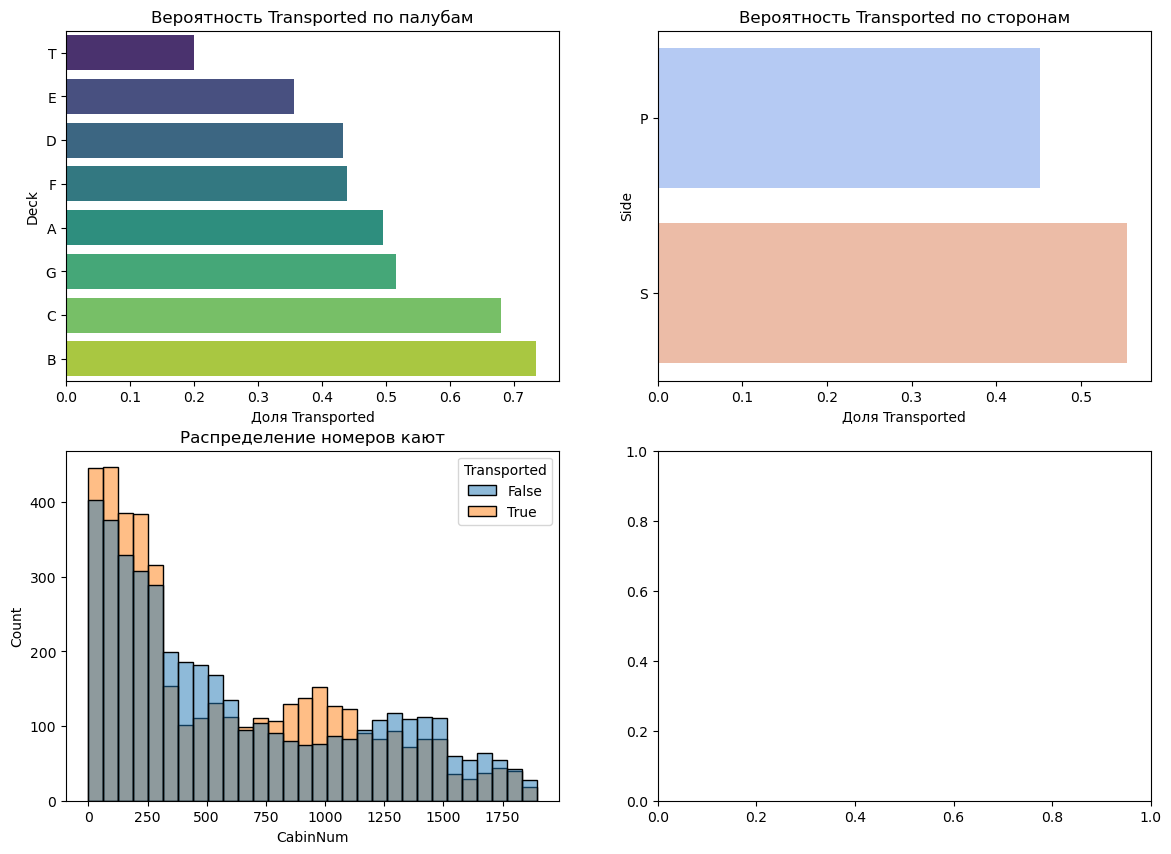

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

deck_counts = train_data.groupby('Deck')['Transported'].mean().sort_values()
sns.barplot(x=deck_counts.values, y=deck_counts.index, ax=axes[0,0], palette='viridis')
axes[0,0].set_title('Вероятность Transported по палубам')
axes[0,0].set_xlabel('Доля Transported')

side_counts = train_data.groupby('Side')['Transported'].mean()
sns.barplot(x=side_counts.values, y=side_counts.index, ax=axes[0,1], palette='coolwarm')
axes[0,1].set_title('Вероятность Transported по сторонам')
axes[0,1].set_xlabel('Доля Transported')

sns.histplot(data=train_data, x='CabinNum', hue='Transported', bins=30, ax=axes[1,0])
axes[1,0].set_title('Распределение номеров кают')

Пассажиры на палубах B и C действительно имеют наибольшие шансы быть транспортированными

In [17]:
train_data.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TotalSpent,HasSpent,Deck,CabinNum,Side
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,0,B,0.0,P
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0,1,F,0.0,S
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,10383.0,1,A,0.0,S
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5176.0,1,A,0.0,S
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1091.0,1,F,1.0,S


### Удалим ненужные столбцы

In [18]:
df = train_data
df.drop(columns = ['PassengerId', 'Cabin', 'Name', 'HasSpent'])

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,TotalSpent,Deck,CabinNum,Side
0,Europa,0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,False,0.0,B,0.0,P
1,Earth,0,TRAPPIST-1e,24.0,109.0,9.0,25.0,549.0,44.0,True,736.0,F,0.0,S
2,Europa,0,TRAPPIST-1e,58.0,43.0,3576.0,0.0,6715.0,49.0,False,10383.0,A,0.0,S
3,Europa,0,TRAPPIST-1e,33.0,0.0,1283.0,371.0,3329.0,193.0,False,5176.0,A,0.0,S
4,Earth,0,TRAPPIST-1e,16.0,303.0,70.0,151.0,565.0,2.0,True,1091.0,F,1.0,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,0,55 Cancri e,41.0,0.0,6819.0,0.0,1643.0,74.0,False,8536.0,A,98.0,P
8689,Earth,1,PSO J318.5-22,18.0,0.0,0.0,0.0,0.0,0.0,False,0.0,G,1499.0,S
8690,Earth,0,TRAPPIST-1e,26.0,0.0,0.0,1872.0,1.0,0.0,True,1873.0,G,1500.0,S
8691,Europa,0,55 Cancri e,32.0,0.0,1049.0,0.0,353.0,3235.0,False,4637.0,E,608.0,S


### Проверим зависимость Transported от HomePlanet

In [19]:
print("Распределение HomePlanet:")
print(train_data['HomePlanet'].value_counts(dropna=False))

print(f"Пропуски в HomePlanet: {train_data['HomePlanet'].isna().sum()} ({train_data['HomePlanet'].isna().mean()*100:.1f}%)")

Распределение HomePlanet:
HomePlanet
Earth     4602
Europa    2131
Mars      1759
0          201
Name: count, dtype: int64
Пропуски в HomePlanet: 0 (0.0%)


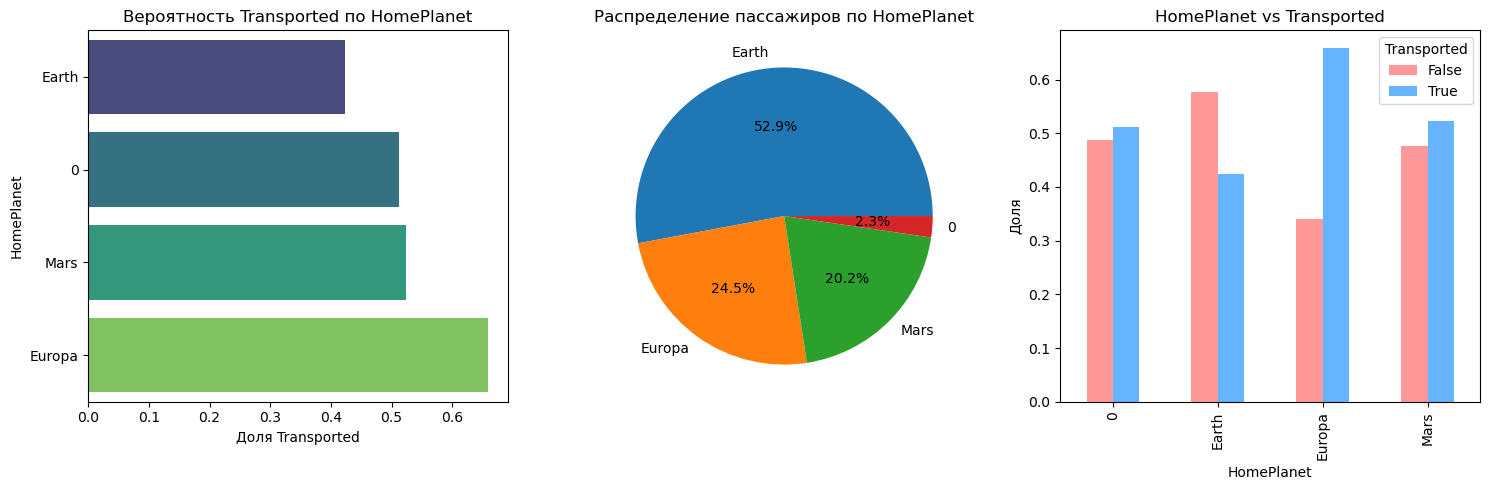

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

planet_means = train_data.groupby('HomePlanet')['Transported'].mean().sort_values()
sns.barplot(x=planet_means.values, y=planet_means.index, ax=axes[0], palette='viridis')
axes[0].set_title('Вероятность Transported по HomePlanet')
axes[0].set_xlabel('Доля Transported')

planet_counts = train_data['HomePlanet'].value_counts()
axes[1].pie(planet_counts.values, labels=planet_counts.index, autopct='%1.1f%%')
axes[1].set_title('Распределение пассажиров по HomePlanet')

ct = pd.crosstab(train_data['HomePlanet'], train_data['Transported'], normalize='index')
ct.plot(kind='bar', ax=axes[2], color=['#ff9999', '#66b3ff'])
axes[2].set_title('HomePlanet vs Transported')
axes[2].set_ylabel('Доля')
axes[2].legend(title='Transported')

plt.tight_layout()
plt.show()


По результатам выведенных графиков можно сделать вывод, что то, откуда прибыл пассажир является важным для прогнозирования модели

In [21]:
train_data.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TotalSpent,HasSpent,Deck,CabinNum,Side
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,0,B,0.0,P
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0,1,F,0.0,S
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,10383.0,1,A,0.0,S
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5176.0,1,A,0.0,S
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1091.0,1,F,1.0,S


In [22]:
df = train_data

## Обучение моделей и кросс-валидация

In [23]:
df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TotalSpent,HasSpent,Deck,CabinNum,Side
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,0,B,0.0,P
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0,1,F,0.0,S
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,10383.0,1,A,0.0,S
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5176.0,1,A,0.0,S
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1091.0,1,F,1.0,S


In [24]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score

def prepare_features(df):
    
    features = pd.DataFrame()
    
    features['Age'] = df['Age'].fillna(df['Age'].median())
    features['TotalSpent'] = df['TotalSpent']
    features['HasSpent'] = df['HasSpent']
    
    features['CryoSleep'] = df['CryoSleep'].astype(int)
    
    planet_dummies = pd.get_dummies(df['HomePlanet'], prefix='Planet', dummy_na=True)
    features = pd.concat([features, planet_dummies], axis=1)

    features['Deck_B'] = (df['Deck'] == 'B').astype(int)
    features['Deck_C'] = (df['Deck'] == 'C').astype(int)
    features['Deck_F'] = (df['Deck'] == 'F').astype(int)
    features['Deck_T'] = (df['Deck'] == 'T').astype(int)

    features['Side_P'] = (df['Side'] == 'P').astype(int)
    features['Side_S'] = (df['Side'] == 'S').astype(int)

    features['CabinNum'] = df['CabinNum'].fillna(df['CabinNum'].median())
    features['CabinNum_scale'] = (features['CabinNum'] - features['CabinNum'].mean()) / features['CabinNum'].std()

    features = features.fillna(0)
    
    return features


X = prepare_features(train_data)
y = train_data['Transported']

print("Размерность признаков:", X.shape)
print("\nПризнаки:", list(X.columns))

Размерность признаков: (8693, 17)

Признаки: ['Age', 'TotalSpent', 'HasSpent', 'CryoSleep', 'Planet_0', 'Planet_Earth', 'Planet_Europa', 'Planet_Mars', 'Planet_nan', 'Deck_B', 'Deck_C', 'Deck_F', 'Deck_T', 'Side_P', 'Side_S', 'CabinNum', 'CabinNum_scale']


In [25]:
def cross_validate_model(model, X, y, cv_folds=5, model_name="Модель"):

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

    results = {
        'model_name': model_name,
        'mean_accuracy': scores.mean(),
        'std_accuracy': scores.std(),
        'min_accuracy': scores.min(),
        'max_accuracy': scores.max(),
        'all_scores': scores
    }
    
    print(f"  Результаты {model_name}:")
    print(f"  Mean Accuracy: {scores.mean():.4f}")
    print(f"  Std: {scores.std():.4f}")
    print(f"  Min: {scores.min():.4f}")
    print(f"  Max: {scores.max():.4f}")
    print(f"  Разброс: {scores.max() - scores.min():.4f}")
    
    return results

In [26]:
def plot_model_comparison(results_list):

    models = [r['model_name'] for r in results_list]
    means = [r['mean_accuracy'] for r in results_list]
    stds = [r['std_accuracy'] for r in results_list]
    
    plt.figure(figsize=(12, 6))
    
    bars = plt.barh(models, means, xerr=stds, capsize=5, color='skyblue')
    plt.xlabel('Accuracy')
    plt.title('Сравнение моделей на кросс-валидации')

    for i, (mean, std) in enumerate(zip(means, stds)):
        plt.text(mean + std + 0.005, i, f'{mean:.4f}', va='center')
    
    plt.axvline(x=0.8, color='red', linestyle='--', alpha=0.5, label='Целевой уровень 80%')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    results_df = pd.DataFrame([{
        'Модель': r['model_name'],
        'Accuracy': f"{r['mean_accuracy']:.4f} ± {r['std_accuracy']:.4f}",
        'Min': f"{r['min_accuracy']:.4f}",
        'Max': f"{r['max_accuracy']:.4f}"
    } for r in results_list])
    
    print("\n Сводная таблица:")
    print(results_df.to_string(index=False))

In [27]:
all_results = []

### Логистическая регрессия

In [28]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_results = cross_validate_model(log_model, X, y, model_name="Logistic Regression")
all_results.append(log_results)

  Результаты Logistic Regression:
  Mean Accuracy: 0.7407
  Std: 0.0071
  Min: 0.7326
  Max: 0.7516
  Разброс: 0.0190


### Random Forest

In [29]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_results = cross_validate_model(rf_model, X, y, model_name="Random Forest")
all_results.append(rf_results)

  Результаты Random Forest:
  Mean Accuracy: 0.7329
  Std: 0.0098
  Min: 0.7227
  Max: 0.7474
  Разброс: 0.0247


### Gradient Boosting

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_results = cross_validate_model(gb_model, X, y, model_name="Gradient Boosting")
all_results.append(gb_results)

  Результаты Gradient Boosting:
  Mean Accuracy: 0.7547
  Std: 0.0054
  Min: 0.7480
  Max: 0.7637
  Разброс: 0.0157


### XGBoost

In [31]:
import sys
!{sys.executable} -m pip install xgboost

In [32]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb_results = cross_validate_model(xgb_model, X, y, model_name="XGBoost")
all_results.append(xgb_results)

  Результаты XGBoost:
  Mean Accuracy: 0.7365
  Std: 0.0044
  Min: 0.7319
  Max: 0.7418
  Разброс: 0.0099


### CatBoost

In [33]:
import sys
!{sys.executable} -m pip install catboost
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(n_estimators=100, random_state=42, verbose=0)
cat_results = cross_validate_model(cat_model, X, y, model_name="CatBoost")
all_results.append(cat_results)

  Результаты CatBoost:
  Mean Accuracy: 0.7551
  Std: 0.0077
  Min: 0.7422
  Max: 0.7642
  Разброс: 0.0220


### Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_results = cross_validate_model(dt_model, X, y, model_name="Decision Tree")
all_results.append(dt_results)

  Результаты Decision Tree:
  Mean Accuracy: 0.7438
  Std: 0.0045
  Min: 0.7388
  Max: 0.7509
  Разброс: 0.0121


### K-Nearest Neighbors

In [35]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=10)
knn_results = cross_validate_model(knn_model, X, y, model_name="KNN")
all_results.append(knn_results)

  Результаты KNN:
  Mean Accuracy: 0.7139
  Std: 0.0059
  Min: 0.7062
  Max: 0.7192
  Разброс: 0.0131


### Naive Bayes

In [36]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_results = cross_validate_model(nb_model, X, y, model_name="Naive Bayes")
all_results.append(nb_results)

  Результаты Naive Bayes:
  Mean Accuracy: 0.7277
  Std: 0.0116
  Min: 0.7146
  Max: 0.7470
  Разброс: 0.0324


### AdaBoost

In [37]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_results = cross_validate_model(ada_model, X, y, model_name="AdaBoost")
all_results.append(ada_results)

  Результаты AdaBoost:
  Mean Accuracy: 0.7394
  Std: 0.0050
  Min: 0.7338
  Max: 0.7470
  Разброс: 0.0132


### Extra Trees

In [38]:
et_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_results = cross_validate_model(et_model, X, y, model_name="Extra Trees")
all_results.append(et_results)

  Результаты Extra Trees:
  Mean Accuracy: 0.7175
  Std: 0.0060
  Min: 0.7100
  Max: 0.7232
  Разброс: 0.0132


### Сравнение моделей

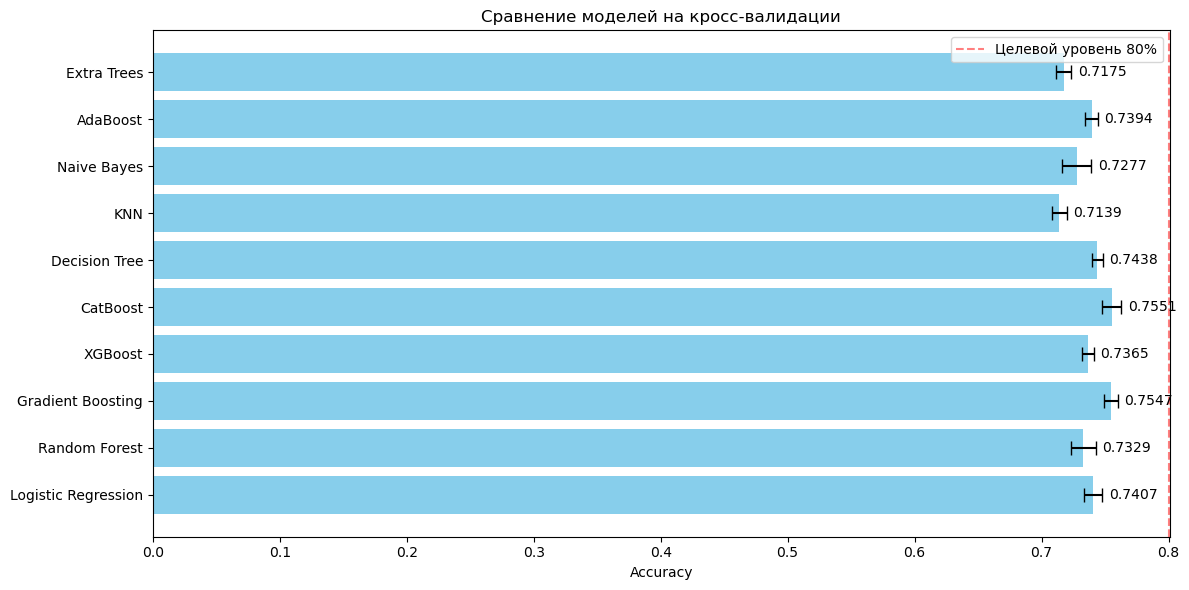


 Сводная таблица:
             Модель        Accuracy    Min    Max
Logistic Regression 0.7407 ± 0.0071 0.7326 0.7516
      Random Forest 0.7329 ± 0.0098 0.7227 0.7474
  Gradient Boosting 0.7547 ± 0.0054 0.7480 0.7637
            XGBoost 0.7365 ± 0.0044 0.7319 0.7418
           CatBoost 0.7551 ± 0.0077 0.7422 0.7642
      Decision Tree 0.7438 ± 0.0045 0.7388 0.7509
                KNN 0.7139 ± 0.0059 0.7062 0.7192
        Naive Bayes 0.7277 ± 0.0116 0.7146 0.7470
           AdaBoost 0.7394 ± 0.0050 0.7338 0.7470
        Extra Trees 0.7175 ± 0.0060 0.7100 0.7232


In [39]:
plot_model_comparison(all_results)

In [40]:
sorted_results = sorted(all_results, key=lambda x: x['mean_accuracy'], reverse=True)

In [43]:
models = [r['model_name'] for r in sorted_results]
means = [r['mean_accuracy'] for r in sorted_results]
print(models)

['CatBoost', 'Gradient Boosting', 'Decision Tree', 'Logistic Regression', 'AdaBoost', 'XGBoost', 'Random Forest', 'Naive Bayes', 'Extra Trees', 'KNN']


## Ансамбль

In [46]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_models = {
    'cat': CatBoostClassifier(iterations=100, random_state=42, verbose=0),
    'gb': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'dt': DecisionTreeClassifier(max_depth=5, random_state=42),
    'lr': LogisticRegression(max_iter=1000, random_state=42)
}

### Вариант 1. Voting classifier

In [47]:
voting_top4 = VotingClassifier(
    estimators=[
        ('cat', best_models['cat']),
        ('gb', best_models['gb']),
        ('dt', best_models['dt']),
        ('lr', best_models['lr'])
    ],
    voting='soft',
    weights=[3, 3, 1, 1]
)
voting_top4_scores = cross_val_score(voting_top4, X, y, cv=cv, scoring='accuracy')
print(f"\nVoting (все 4 модели):")
print(f"  Accuracy: {voting_top4_scores.mean():.4f} (+/- {voting_top4_scores.std()*2:.4f})")
print(f"  Улучшение от CatBoost: +{(voting_top4_scores.mean() - 0.7551)*100:.2f}%")


Voting (все 4 модели):
  Accuracy: 0.7558 (+/- 0.0089)
  Улучшение от CatBoost: +0.07%


### Вариант 2. Stacking Classifier

In [48]:
stacking_lr = StackingClassifier(
    estimators=[
        ('cat', best_models['cat']),
        ('gb', best_models['gb']),
        ('dt', best_models['dt'])
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5
)

stacking_lr_scores = cross_val_score(stacking_lr, X, y, cv=cv, scoring='accuracy')
print(f"\nStacking (мета-модель Logistic Regression):")
print(f"  Accuracy: {stacking_lr_scores.mean():.4f} (+/- {stacking_lr_scores.std()*2:.4f})")
print(f"  Улучшение от CatBoost: +{(stacking_lr_scores.mean() - 0.7551)*100:.2f}%")



Stacking (мета-модель Logistic Regression):
  Accuracy: 0.7560 (+/- 0.0112)
  Улучшение от CatBoost: +0.09%


In [49]:
from sklearn.ensemble import RandomForestClassifier

stacking_rf = StackingClassifier(
    estimators=[
        ('cat', best_models['cat']),
        ('gb', best_models['gb'])
    ],
    final_estimator=RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42),
    cv=5
)

stacking_rf_scores = cross_val_score(stacking_rf, X, y, cv=cv, scoring='accuracy')
print(f"\nStacking (мета-модель Random Forest):")
print(f"  Accuracy: {stacking_rf_scores.mean():.4f} (+/- {stacking_rf_scores.std()*2:.4f})")
print(f"  Улучшение от CatBoost: +{(stacking_rf_scores.mean() - 0.7551)*100:.2f}%")


Stacking (мета-модель Random Forest):
  Accuracy: 0.7549 (+/- 0.0131)
  Улучшение от CatBoost: +-0.02%


### Вариант 3. Weighted voting

In [51]:
from sklearn.base import BaseEstimator, ClassifierMixin

class WeightedAverageEnsemble(BaseEstimator, ClassifierMixin):
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights
    
    def fit(self, X, y):
        self.weights_normalized_ = np.array(self.weights) / sum(self.weights)
        
        self.models_ = []
        for model in self.models:
            model_copy = model.__class__(**model.get_params())
            model_copy.fit(X, y)
            self.models_.append(model_copy)
        return self
    
    def predict_proba(self, X):
        probas = np.zeros((X.shape[0], 2))
        for model, weight in zip(self.models_, self.weights_normalized_):
            probas += weight * model.predict_proba(X)
        return probas
    
    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

    def get_params(self, deep=True):
        return {
            'models': self.models,
            'weights': self.weights
        }
    
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

weighted_ensemble = WeightedAverageEnsemble(
    models=[best_models['cat'], best_models['gb'], best_models['dt']],
    weights=[0.5, 0.3, 0.2]
)

weighted_scores = cross_val_score(weighted_ensemble, X, y, cv=cv, scoring='accuracy')
print(f"\nВзвешенное усреднение (CatBoost 50%, GB 30%, DT 20%):")
print(f"  Accuracy: {weighted_scores.mean():.4f} (+/- {weighted_scores.std()*2:.4f})")
print(f"  Улучшение от CatBoost: +{(weighted_scores.mean() - 0.7551)*100:.2f}%")


Взвешенное усреднение (CatBoost 50%, GB 30%, DT 20%):
  Accuracy: 0.7559 (+/- 0.0084)
  Улучшение от CatBoost: +0.08%


Наилучший ансамбль - Stacking Classifier с Logistic Regression

In [52]:
final_stacking = StackingClassifier(
    estimators=[
        ('cat', best_models['cat']),
        ('gb', best_models['gb']),
        ('dt', best_models['dt'])
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5
)

In [54]:
final_stacking.fit(X, y)

,estimators,"[('cat', ...), ('gb', ...), ...]"
,final_estimator,LogisticRegre...ndom_state=42)
,cv,5
,stack_method,'auto'
,n_jobs,None
,passthrough,False
,verbose,0
,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0


## Улучшение модели

In [61]:
import sys
!{sys.executable} -m pip install lightgbm xgboost catboost

In [62]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import pandas as pd
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def check_accuracy(X, y, model_name="Текущая модель"):
    from catboost import CatBoostClassifier
    model = CatBoostClassifier(iterations=100, random_state=42, verbose=0)
    
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    
    print(f"\n {model_name}:")
    print(f"  Accuracy: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")
    print(f"  Min: {scores.min():.4f}, Max: {scores.max():.4f}")
    
    return scores.mean()

baseline_score = check_accuracy(X, y, "БАЗОВАЯ МОДЕЛЬ (без новых признаков)")


 БАЗОВАЯ МОДЕЛЬ (без новых признаков):
  Accuracy: 0.7551 (+/- 0.0153)
  Min: 0.7422, Max: 0.7642


In [65]:
X_step1 = X.copy()

X_step1['Group'] = train_data['PassengerId'].apply(lambda x: str(x).split('_')[0])
X_step1['GroupSize'] = X_step1.groupby('Group')['Group'].transform('count')
X_step1['IsAlone'] = (X_step1['GroupSize'] == 1).astype(int)

X_step1 = X_step1.drop(columns=['Group'])

step1_score = check_accuracy(X_step1, y, "ПОСЛЕ GroupSize")
improvement1 = (step1_score - baseline_score) * 100
print(f" Улучшение: {improvement1:.2f}%")


 ПОСЛЕ GroupSize:
  Accuracy: 0.7523 (+/- 0.0106)
  Min: 0.7474, Max: 0.7591
 Улучшение: -0.28%


In [66]:
X_step2 = X_step1.copy()

X_step2['LastName'] = train_data['Name'].apply(lambda x: str(x).split()[-1] if pd.notna(x) else 'Unknown')
X_step2['FamilySize'] = X_step2.groupby('LastName')['LastName'].transform('count')

X_step2 = X_step2.drop(columns=['LastName'])

step2_score = check_accuracy(X_step2, y, "ПОСЛЕ FamilySize")
improvement2 = (step2_score - step1_score) * 100
total_improvement = (step2_score - baseline_score) * 100
print(f" Улучшение от прошлого шага: +{improvement2:.2f}%")
print(f" Общее улучшение: {total_improvement:.2f}%")


 ПОСЛЕ FamilySize:
  Accuracy: 0.7513 (+/- 0.0139)
  Min: 0.7424, Max: 0.7602
 Улучшение от прошлого шага: +-0.10%
 Общее улучшение: -0.38%


In [68]:
X_step3 = X_step2.copy()

X_step3['AgeGroup'] = pd.cut(train_data['Age'].fillna(train_data['Age'].median()), 
                              bins=[0, 12, 18, 30, 50, 100],
                              labels=['Child', 'Teen', 'Young', 'Middle', 'Senior'])

age_dummies = pd.get_dummies(X_step3['AgeGroup'], prefix='Age')
X_step3 = pd.concat([X_step3.drop(columns=['AgeGroup']), age_dummies], axis=1)

step3_score = check_accuracy(X_step3, y, "ПОСЛЕ AgeGroup")
improvement3 = (step3_score - step2_score) * 100
total_improvement = (step3_score - baseline_score) * 100
print(f" Улучшение от прошлого шага: +{improvement3:.2f}%")
print(f" Общее улучшение: {total_improvement:.2f}%")


 ПОСЛЕ AgeGroup:
  Accuracy: 0.7480 (+/- 0.0117)
  Min: 0.7388, Max: 0.7562
 Улучшение от прошлого шага: +-0.33%
 Общее улучшение: -0.71%


In [70]:
X_step4 = X_step3.copy()
X_step4['SpentPerPerson'] = X_step4['TotalSpent'] / (X_step4['GroupSize'] + 1)
X_step4['Cryo_Alone'] = X_step4['CryoSleep'] * X_step4['IsAlone']
X_step4['Spent_Alone'] = X_step4['TotalSpent'] * X_step4['IsAlone']
X_step4['SpentPerAge'] = X_step4['TotalSpent'] / (X_step4['Age'] + 1)

step4_score = check_accuracy(X_step4, y, "ПОСЛЕ взаимодействий")
improvement4 = (step4_score - step3_score) * 100
total_improvement = (step4_score - baseline_score) * 100
print(f" Улучшение от прошлого шага: +{improvement4:.2f}%")
print(f" Общее улучшение: {total_improvement:.2f}%")


 ПОСЛЕ взаимодействий:
  Accuracy: 0.7451 (+/- 0.0085)
  Min: 0.7384, Max: 0.7510
 Улучшение от прошлого шага: +-0.29%
 Общее улучшение: -1.00%


Модель не улучшается